## Introduction

In [ ]:
# !pip install kaggle
# !pip install sympy

In [2]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [5]:
import torch
import numpy as np
import pandas as pd

# add this to use up more of the screen
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

In [4]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Clean up missing values
Replace with most common occurrances for each column

In [8]:
# find how many rows for ech col are nan
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [13]:
# find the mode (most frequent occurance) of each column

modes = df.mode().iloc[0] # return the zero row when there are more than one mode
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [14]:
# fill missing values with modes
df.fillna(modes, inplace=True)

### View data after cleaning

In [15]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [16]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Turn skewed features into log form: Fare

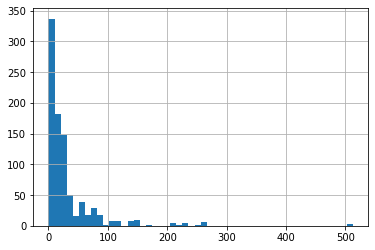

In [18]:
df['Fare'].hist(bins=50);

In [26]:
# turn into a centered distribution
df['LogFare'] = np.log(df['Fare']+1) # add 1 to avoid log of 0

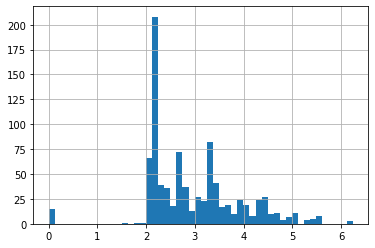

In [27]:
df['LogFare'].hist(bins=50);

## Categorical Variables

In [28]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [29]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,691,646


### Convert categorical vairables into dummy variables

In [31]:
# make dummy variables
df = pd.get_dummies(df, columns=["Sex","Pclass","Embarked"])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [32]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,0,1,0,0,1
1,0,1,1,0,0,1,0,0
2,0,1,0,0,1,0,0,1
3,0,1,1,0,0,0,0,1
4,1,0,0,0,1,0,0,1


### Target Variable : Survived

In [33]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

## Convert data to tensor

In [38]:
from torch import tensor
t_dep = tensor(df.Survived)

# view the first 10
t_dep[:10]

tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])

In [43]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float) # ensure all are the same data:type convert to floats
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [45]:
t_indep.shape # rows x columns

torch.Size([891, 12])

In [46]:
# rank : number of axis or dimentions
len(t_indep.shape)

2

## Setting up a linear model

In [ ]:
torch.manual_seed(442)

# ceofficient for each features
n_coeff = t_indep.shape[1]

# center around zero by minus 5
coeffs = torch.rand(n_coeff)-0.5
coeffs

In [ ]:
t_indep.shape, coeffs.shape

In [ ]:
# element-wise multiplication: broadcasting
t_indep*coeffs

In [ ]:
# divide by max of each row
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [ ]:
t_indep*coeffs

In [ ]:
# add up over the columns
preds = (t_indep*coeffs).sum(axis=1)

In [ ]:
preds[:10]

In [ ]:
# MAE as loss
loss = torch.abs(preds-t_dep).mean()
loss

In [ ]:
def calc_preds(coeffs, indeps): 
    # calculate predictions
    return (indeps*coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps): 
    # MAE
    return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Doing a gradient descent step

In [ ]:
# calculate derivatives for coeffes 
coeffs.requires_grad_()

In [ ]:
# stores the gradient function
loss = calc_loss(coeffs, t_indep, t_dep)
loss

In [ ]:
loss.backward()

In [ ]:
coeffs.grad

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
coeffs.grad

In [ ]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss.backward()
with torch.no_grad():
    # subtract in place from coeff the grad * lr
    coeffs.sub_(coeffs.grad * 0.1) 
    coeffs.grad.zero_()
    print(calc_loss(coeffs, t_indep, t_dep))

## Training the linear model

In [ ]:
from fastai.data.transforms import RandomSplitter
# split index
trn_split,val_split=RandomSplitter(seed=42)(df)

In [ ]:
# split train and val
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [ ]:
# len independent vars 
len(trn_indep),len(val_indep)

In [ ]:
# shape of independent vars
trn_indep.shape,val_indep.shape

In [ ]:
# len dependent 
len(trn_dep),len(val_dep)

In [ ]:
# shape of dependent vars
trn_dep.shape,val_dep.shape

In [ ]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [ ]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [ ]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [ ]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

In [ ]:
coeffs = train_model(18, lr=0.2)

In [ ]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

## Measuring accuracy

In [ ]:
preds = calc_preds(coeffs, val_indep)

In [ ]:
results = val_dep.bool()==(preds>0.5)
results[:16]

In [ ]:
results.float().mean()

In [ ]:
def acc(coeffs): 
    return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

## Using sigmoid

In [ ]:
preds[:28]

In [ ]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-10,10));

In [ ]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [ ]:
coeffs = train_model(lr=100)

In [ ]:
acc(coeffs)

In [ ]:
show_coeffs()

## Submitting to Kaggle

In [ ]:
tst_df = pd.read_csv(path/'test.csv')

In [ ]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [ ]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare']+1)
tst_df = pd.get_dummies(tst_df, columns=["Sex","Pclass","Embarked"])

tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float)
tst_indep = tst_indep / vals

In [ ]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs)>0.5).int()

In [ ]:
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)

In [ ]:
!head sub.csv

## Using matrix product

In [ ]:
# this is the same as matrix multiply
(val_indep*coeffs).sum(axis=1)

In [ ]:
# equivalent in python
val_indep@coeffs

In [ ]:
def calc_preds(coeffs, indeps): 
    # treat as matrix multi with another matrix
    return torch.sigmoid(indeps@coeffs)

In [ ]:
def init_coeffs(): 
    # use column vector for coeff
    # n_coeff by 1 matrix
    return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

In [ ]:
# before
trn_dep.shape

In [ ]:
# turn n rowsx1 vector into a nrowsx1 matrix
# add a "second" dimention as None
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

In [ ]:
# after
trn_dep.shape

In [ ]:
coeffs = train_model(lr=100)

In [ ]:
acc(coeffs)

In [ ]:
coeffs.shape

## A neural network

In [ ]:
def init_coeffs(n_hidden=20):
    
    # n hidden: number of hidden activations
    
    # input to hidden layer: 
    # divide by nhidden to keep coefficients to a decent size
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden
    
    # hidden to output layer
    layer2 = torch.rand(n_hidden, 1)-0.3
    
    # cobstant term for layer 2
    const = torch.rand(1)[0]
    
    return (layer1.requires_grad_(),
            layer2.requires_grad_(),
            const.requires_grad_())

In [ ]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    
    # get tuple output
    l1,l2,const = coeffs
    
    # replace negatives with zeros
    # first layer
    res = F.relu(indeps@l1)
    
    # second layer adds a constant term
    res = res@l2 + const
    
    return torch.sigmoid(res)

In [ ]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [ ]:
coeffs = train_model(lr=1.4)

In [ ]:
coeffs = train_model(lr=20)

In [ ]:
acc(coeffs)

## Deep learning

In [ ]:
def init_coeffs():
    
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    
    sizes = [n_coeff] + hiddens + [1]
    
    n = len(sizes)
    
    # for each hidden layer  
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    
    # constant term
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    
    # stick req grad to all
    for l in layers+consts: 
        l.requires_grad_()
    
    return layers,consts

In [ ]:
import torch.nn.functional as F
def calc_preds(coeffs, indeps):
    
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        
        #as long as is not the last layer, do the relu
        if i!=n-1: res = F.relu(res)
    
    # sigmois is at the end always
    return torch.sigmoid(res)

In [ ]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [ ]:
coeffs = train_model(lr=4)

In [ ]:
acc(coeffs)

## Final thoughts